# EAM parameter file checks

This Notebook is designed to perform checks on LAMMPS-compatible EAM parameter files based on known possible issues.

In [2]:
from pathlib import Path

import numpy as np

import matplotlib.pyplot as plt
 
import potentials

## Load parameter file

The first check is if the potentials package can successfully load the parameter file.  Note that the reader is not a 100% match for the LAMMPS reader, so there may be some differences.

Known differences:

- LAMMPS ignores lattice type and is not required to be given.  potentials will fail to load if the lattice type is missing.
- LAMMPS ignores blank lines.  potentials will fail if the header lines do not correspond to the correct line number.  This may be especially troublesome for Mac-style "CR" line endings. 
- Newer versions of LAMMPS do not allow NaN or INF values in the tabulations (check for this is below).



### From filepath

In [3]:
fname = Path('F:/website/new potentials/CuAgAu.eam.fs')
eam = potentials.paramfile.load_eam(fname)

### From potentials library

In [5]:
lammps_potential_id = '1985--Foiles-S-M--Ni-Cu--LAMMPS--ipr1'

potdb = potentials.Database(local=True, remote=False)
lmppot = potdb.get_lammps_potential(id=lammps_potential_id, pot_dir_style='local')

if len(lmppot.artifacts) == 1:
    fname = lmppot.artifacts[0].filename
elif len(lmppot.artifacts) > 1:
    print('Multiple artifacts for the potential')
    for i, artifact in enumerate(lmppot.artifacts):
        print(i+1, artifact.filename)
    i = int(input('Enter selection:'))
    fname = lmppot.artifacts[i-1].filename
else:
    raise ValueError('No parameter file artifacts found for the potential!')
    
eam = potentials.paramfile.load_eam(Path(lmppot.pot_dir, fname))

Multiple artifacts for the potential
1 Cu_smf7.eam
2 Ni_smf7.eam


Enter selection: 


ValueError: invalid literal for int() with base 10: ''

## Check identified format

This will print the identified LAMMPS pair_style for the parameter file.  

__NOTE__: the eam/alloy and eam/fs formats are identical for single element potentials and will show up as eam/alloy.

In [4]:
print('pair_style', eam.pair_style)

pair_style eam/fs


## Check for INF and NaN values

Newest versions of LAMMPS no longer allow for non-finite floating point numbers.  This checks if these exist in the tables.

In [5]:
def finite_check(values):
    numfinite = np.sum(np.isfinite(values))
    if values.shape[0] == numfinite:
        print('is good')
    else:
        print('contains non-finite numbers!')

if eam.pair_style == 'eam':
    print('F(ρ)', end=' ')
    finite_check(eam.F_rho())
    print('ρ(r)', end=' ')
    finite_check(eam.rho_r())
    print('z(r)', end=' ')
    finite_check(eam.z_r())

else:
    for symbol in eam.symbols:
        print(f'F(ρ) {symbol}', end=' ')
        finite_check(eam.F_rho(symbol))
    
    if eam.pair_style == 'eam/alloy':
        for symbol in eam.symbols:
            print(f'ρ(r) {symbol}', end=' ')
            finite_check(eam.rho_r(symbol))
    elif eam.pair_style == 'eam/fs':
        for symbol1 in eam.symbols:
            for symbol2 in eam.symbols:
                print(f'ρ(r) {symbol1}-{symbol2}', end=' ')
                finite_check(eam.rho_r([symbol1, symbol2]))
    
    for i, symbol1 in enumerate(eam.symbols):
        for symbol2 in eam.symbols[:i+1]:
            print(f'r*ϕ(r) {symbol1}-{symbol2}', end=' ')
            finite_check(eam.rphi_r([symbol1, symbol2]))

F(ρ) Cu is good
F(ρ) Ag is good
F(ρ) Au is good
ρ(r) Cu-Cu is good
ρ(r) Cu-Ag is good
ρ(r) Cu-Au is good
ρ(r) Ag-Cu is good
ρ(r) Ag-Ag is good
ρ(r) Ag-Au is good
ρ(r) Au-Cu is good
ρ(r) Au-Ag is good
ρ(r) Au-Au is good
r*ϕ(r) Cu-Cu is good
r*ϕ(r) Ag-Cu is good
r*ϕ(r) Ag-Ag is good
r*ϕ(r) Au-Cu is good
r*ϕ(r) Au-Ag is good
r*ϕ(r) Au-Au is good


## Check for non-zero isolated energies

This checks if F(ρ=0) == 0.  If this is not true, then the potential will have a non-zero isolated atom energy meaning that the measured potential energy will be different from the cohesive energy.

__NOTE:__ While a zero isolated atom energy is typically wanted, some potentials do purposefully have non-zero isolated atom energies.

In [6]:
if eam.pair_style == 'eam':
    if eam.F_rho()[0] == 0.0:
        print('Good: isolated energy will be zero')
    else:
        print('Caution: isolated energy will not be zero!')

else:
    for symbol in eam.symbols:
        print(f'{symbol:2}', end=' ')
        if eam.F_rho(symbol)[0] == 0.0:
            print('Good: isolated energy will be zero')
        else:
            print('Caution: isolated energy will not be zero!')

Cu Good: isolated energy will be zero
Ag Good: isolated energy will be zero
Au Good: isolated energy will be zero


## Check rho range

A possible insidious issue is if the F(ρ) tabulations do not go to a high enough rho value.  This results in LAMMPS extrapolating the F(ρ) function leading to incorrect predictions.

Here, an ideal fcc cell is used to test for what alat the maximum tabulation ρ is exceeded.  This should ideally be much smaller than the expected lattice parameter. 


In [7]:
# Table up to 6 unit cells of interatomic spacings and counts for an ideal fcc unit cell
counts = np.array([12,6,24,12,24,8,48,6,36,24,24,24,72,48,12,48,30,72,24,48,24,48,8,84,24,96,48,24,96,6,96,48,48,36,120,24,48,24,48,48,
          120,24,120,96,24,108,30,48,72,72,32,144,96,72,72,48,120,144,12,48,48,168,48,96,48,48,30])
ds = np.array([0.70710678118655,1.00000000000000,1.22474487139158,1.41421356237309,1.58113883008418,1.73205080756887,1.87082869338697,2.00000000000000,2.12132034355964,
      2.23606797749979,2.34520787991171,2.44948974278317,2.54950975679639,2.73861278752583,2.82842712474619,2.91547594742265,3.00000000000000,3.08220700148448,
      3.16227766016837,3.24037034920393,3.31662479035540,3.39116499156263,3.46410161513775,3.53553390593273,3.60555127546398,3.67423461417476,3.74165738677394,
      3.80788655293195,3.93700393700590,4.00000000000000,4.06201920231798,4.12310562561766,4.18330013267037,4.24264068711928,4.30116263352131,4.35889894354067,
      4.41588043316392,4.47213595499958,4.52769256906870,4.58257569495584,4.63680924774785,4.69041575982343,4.74341649025256,4.84767985741632,4.89897948556635,
      4.94974746830583,5.00000000000000,5.04975246918103,5.09901951359278,5.14781507049350,5.19615242270663,5.24404424085075,5.33853912601565,5.38516480713450,
      5.43139024560010,5.47722557505166,5.52268050859363,5.61248608016091,5.65685424949238,5.70087712549569,5.74456264653802,5.78791845139511,5.83095189484530,
      5.87367006223536,5.91607978309961,5.95818764390649,6.00000000000000])

In [8]:
alatmin = eam.cutoffr / 6

if eam.pair_style == 'eam':
    stop = False
    for a in np.linspace(10, alatmin, 1000):
        ρbar = np.sum(eam.rho_r(r=(a * ds)) * counts)
        if ρbar > eam.rho[-1]:
            print(f'ρ exceeds F(ρ) tabulation for ideal fcc with alat < {a}')
            stop = True
            break
    if stop is False:
        print(f'ρ does not exceed F(ρ) tabulation for ideal fcc with alat down to at least {alatmin}')
    
elif eam.pair_style == 'eam/alloy':
    for symbol in eam.symbols:
        print(f'{symbol:2}', end=' ')
        stop = False
        for a in np.linspace(10, alatmin, 1000):
            ρbar = np.sum(eam.rho_r(symbol, r=(a * ds)) * counts)
            if ρbar > eam.rho[-1]:
                print(f'ρ exceeds F(ρ) tabulation for ideal fcc with alat < {a}')
                stop = True
                break
        if stop is False:
            print(f'ρ does not exceed F(ρ) tabulation for ideal fcc with alat down to at least {alatmin}')
            
elif eam.pair_style == 'eam/fs':
    for symbol1 in eam.symbols:
        for symbol2 in eam.symbols:
            print(f'{symbol1:2}-{symbol2:2}', end=' ')
            stop = False
            for a in np.linspace(10, alatmin, 1000):
                ρbar = np.sum(eam.rho_r([symbol1, symbol2], r=(a * ds)) * counts)
                if ρbar > eam.rho[-1]:
                    print(f'ρ exceeds F(ρ) tabulation for ideal fcc with alat < {a}')
                    stop = True
                    break
            if stop is False:
                print(f'ρ does not exceed F(ρ) tabulation for ideal fcc with alat down to at least {alatmin}')

Cu-Cu ρ exceeds F(ρ) tabulation for ideal fcc with alat < 1.549710936961862
Cu-Ag ρ exceeds F(ρ) tabulation for ideal fcc with alat < 1.6322870515843846
Cu-Au ρ exceeds F(ρ) tabulation for ideal fcc with alat < 1.9534163862275271
Ag-Cu ρ exceeds F(ρ) tabulation for ideal fcc with alat < 1.6322870515843846
Ag-Ag ρ exceeds F(ρ) tabulation for ideal fcc with alat < 1.7148631662069072
Ag-Au ρ exceeds F(ρ) tabulation for ideal fcc with alat < 2.0543427485439443
Au-Cu ρ exceeds F(ρ) tabulation for ideal fcc with alat < 1.9534163862275271
Au-Ag ρ exceeds F(ρ) tabulation for ideal fcc with alat < 2.0543427485439443
Au-Au ρ exceeds F(ρ) tabulation for ideal fcc with alat < 2.421347702421822


## Check function smoothness

Plots of the EAM tabulated functions and their derivatives can reveal discontinuities that may cause issues for the behavior of the potentials.  Smoothness of the functions is typically checked out to the third derivative as discontinuities in the third derivative can result in sudden changes in static measurements of elastic constants. Discontinuities can be due either to the potential's functional form itself or to how the values are tabulated. 

Based on personal experience, some previously identified sources of discontinuities are:

- Piecewise functional forms may have discontinuities at the junction points where the underlying functions change.  This is an inherent "feature" of these potentials and any associated parameterization will show artifact behaviors for configurations corresponding to the discontinuities.

- A discontinuity may arise at the cutoff distance if no smoothing function is applied, or if the smoothing function itself is not smooth to the wanted derivative.  While potentials can be "corrected" by adding a smoothing cutoff function, it will alter the behavior of the potential and therefore may behave differently for important property predictions.  

- Some tabulations use a constant value for very small r.  Setting a constant value indicates that the potentials were not designed for small r studies (e.g. radiation studies) and may be due to the functional form being unrealistic for those small values (e.g. goes to infinity or flips sign).  

- A discontinuity will occur at the cutoff if the cutoff used for the tabulated values is smaller than the associated function's cutoff.  This indicates that the function(s) should be retabulated up to the correct cutoff value.

- Higher derivative functions may appear wavy due to the numerical precision of the tabulated values.  This could be due to unwanted single-double precision floating point conversions or a loss of precision smoothness due to function manipulation, and therefore may or may not be fixable.  

__NOTES__: This is primarily meant to be a discovery tool to explore a potential's functional forms. The presence of discontinuities does not automatically mean that the potential or parameterization is bad, it simply means that further investigation as to the source of the discontinuity may be warranted.


### F(ρ)

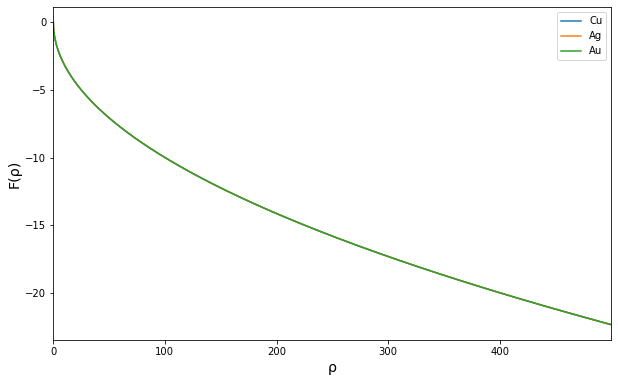

In [16]:
eam.plot_F_rho()
None

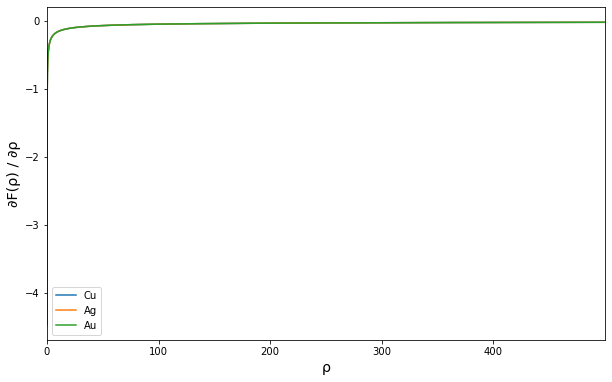

In [10]:
eam.plot_F_rho(n=1)
None

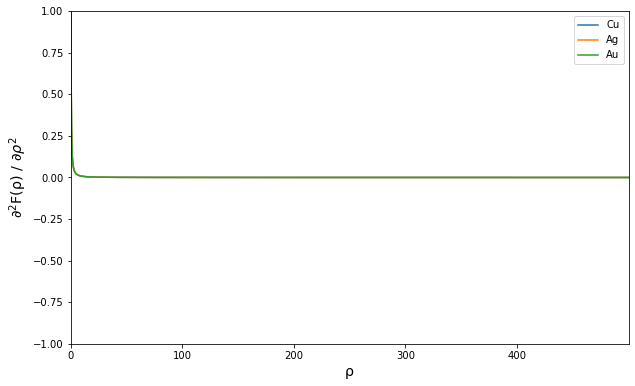

In [11]:
eam.plot_F_rho(n=2, ylim=(-1, 1))
None

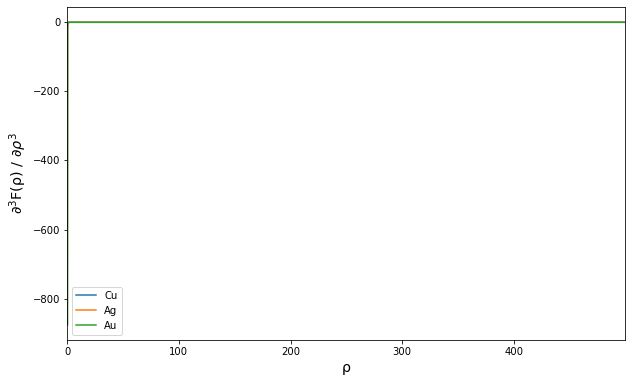

In [14]:
eam.plot_F_rho(n=3)
None

### ρ(r)

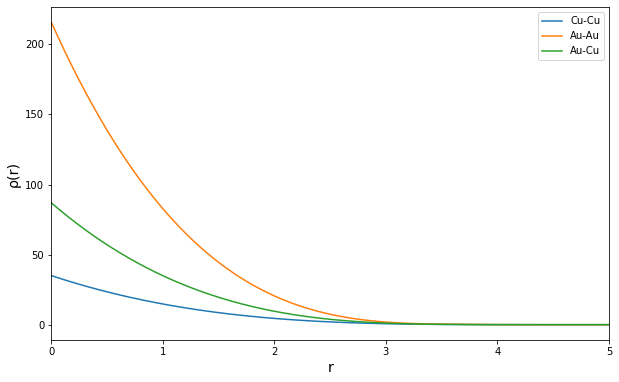

In [39]:
eam.plot_rho_r(symbols=['Cu', 'Au', ['Au', 'Cu']])
None

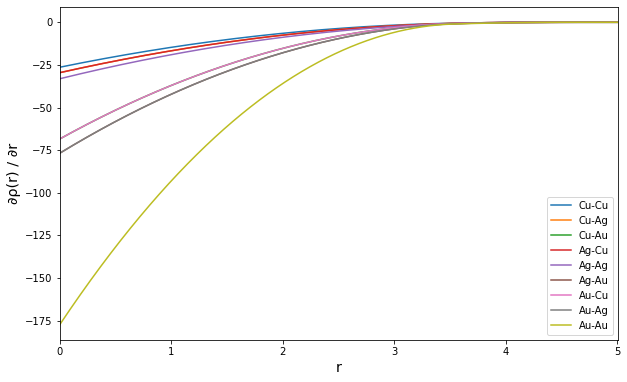

In [17]:
eam.plot_rho_r(n=1)
None

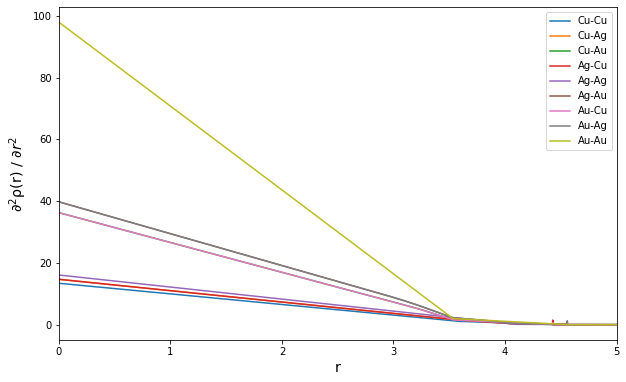

In [18]:
eam.plot_rho_r(n=2)
None

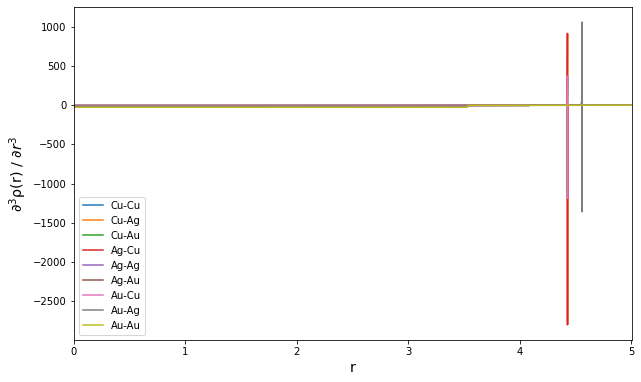

In [19]:
eam.plot_rho_r(n=3)
None

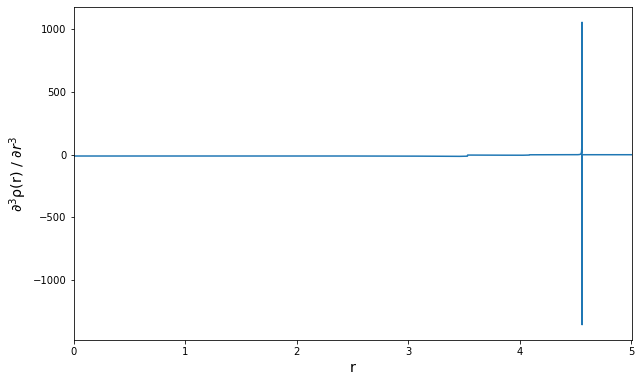

In [34]:
eam.plot_rho_r(n=3, symbols=[['Ag', 'Au']])
None

### r*ϕ(r)

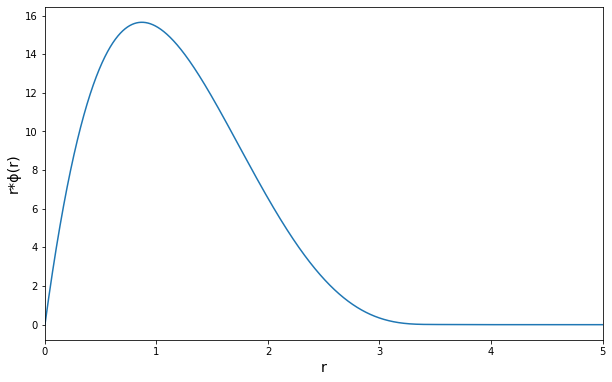

In [36]:
eam.plot_rphi_r(symbols=[['Ag', 'Au']])
None

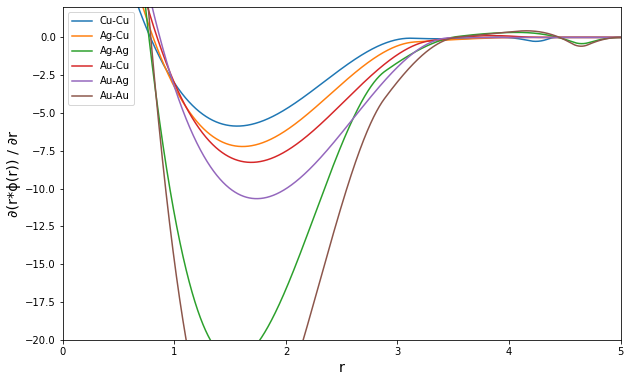

In [21]:
eam.plot_rphi_r(n=1, ylim=(-20, 2))
None

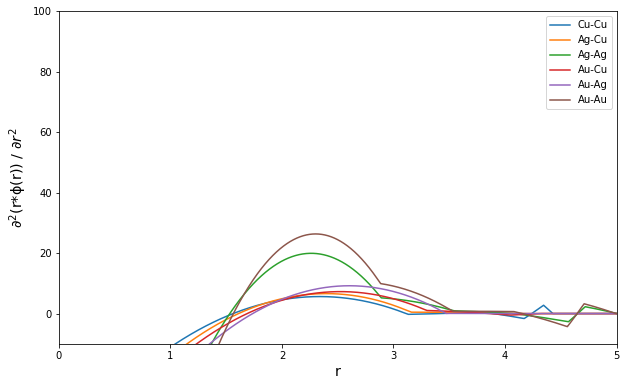

In [22]:
eam.plot_rphi_r(n=2, ylim=(-10, 100))
None

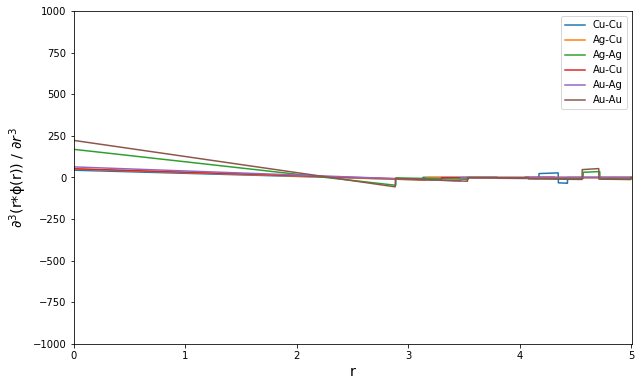

In [23]:
eam.plot_rphi_r(n=3, ylim=(-1000, 1000))
None